In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


This is the setup: there are two reigons, one with a potential signal and one without any signal.  We know that the distribution of background events is the same in the two regions.  

These are four parameters that govern the toy: (1) the number of background events (assumed to be the same in both regions), (2) the fraction of background events that are signal in the signal region, (3) how different the signal is from the background.  When Strangeness -> 0, then the signal is right at the most probable value of the background and when strangeness -> 1, it is a approximately a truth bit (e.g. no overlapping support with the background), and (4) how one-dimensional-like the background is (for the auto-encoder, it won't be useful when corr -> 0).

In [307]:
B = 1e4
SoverB = 0.1
Strangeness = 0.2
corr = -0.8

In [308]:
means = [0.,0.]  
stds = [1.,1.]
covs = [[stds[0]**2, stds[0]*stds[1]*corr], [stds[0]*stds[1]*corr,stds[1]**2]] 

bgeventsSR = np.clip(np.random.multivariate_normal(means, covs, int(B)),-4,4)
bgeventsCR = np.clip(np.random.multivariate_normal(means, covs, int(B)),-4,4)

signal_center = np.ones(2)*Strangeness*3
signal_variances = np.ones(2)*0.08**2
signal_cov = np.diag(signal_variances)
sgeventsSR = np.clip(np.random.multivariate_normal(signal_center, signal_cov,int(B*SoverB)),-4,4)

bg_plus_signal_SR = np.random.permutation(np.append(bgeventsSR,sgeventsSR,axis=0))
bg_plus_signal_CR = bgeventsCR

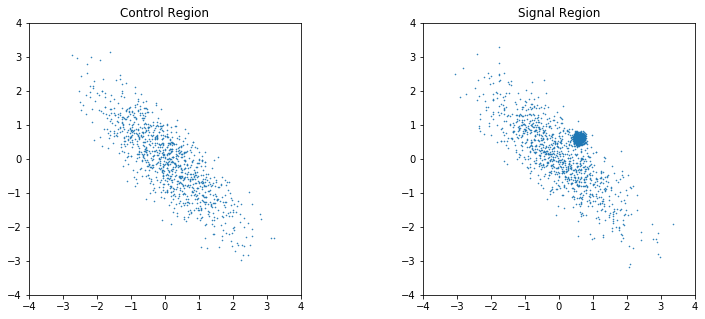

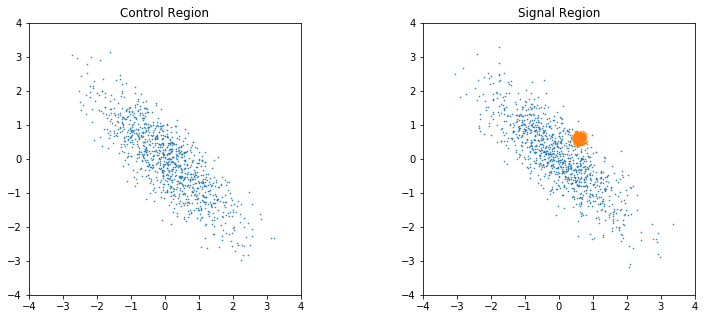

In [309]:
plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.scatter(bg_plus_signal_CR[:,0],bg_plus_signal_CR[:,1],s=0.3,color='C0')
plt.gca().set_aspect(1.)
plt.title("Control Region")
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.subplot(1, 3, 2)
plt.scatter(bg_plus_signal_SR[:,0],bg_plus_signal_SR[:,1],s=0.3,color='C0')
plt.gca().set_aspect(1.)
plt.title("Signal Region")
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.show()

plt.figure(figsize=(20,5))

plt.subplot(1, 3, 1)
plt.scatter(bgeventsCR[:,0],bgeventsCR[:,1],s=0.3,color='C0')
plt.gca().set_aspect(1.)
plt.title("Control Region")
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.subplot(1, 3, 2)
plt.scatter(bgeventsSR[:,0],bgeventsSR[:,1],s=0.3,color='C0')
plt.scatter(sgeventsSR[:,0],sgeventsSR[:,1],s=0.3,color='C1')
plt.gca().set_aspect(1.)
plt.title("Signal Region")
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.show()

Now, let's do some machine learning!  To start, let's do some autoencoding.

In [278]:
encoding_dim = 1

input_img = Input(shape=(2,))
encoded = Dense(128, activation='elu')(input_img)
encoded = Dense(64, activation='elu')(encoded)
encoded = Dense(encoding_dim, activation='linear')(encoded)

decoded = Dense(encoding_dim, activation='elu')(encoded)
decoded = Dense(128, activation='elu')(decoded)
decoded = Dense(2, activation='linear')(decoded)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

In [279]:
autoencoder.compile(optimizer='adam', loss='mse')

In [280]:
autoencoder.fit(bg_plus_signal_CR, bg_plus_signal_CR,
                epochs=50,
                batch_size=100,
                validation_data=(bg_plus_signal_CR, bg_plus_signal_CR))

Train on 1000 samples, validate on 1000 samples
Epoch 1/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.9850 - val_loss: 0.7613
Epoch 2/50
1000/1000 [==============================] - 0s 102us/step - loss: 0.5358 - val_loss: 0.4021
Epoch 3/50
1000/1000 [==============================] - 0s 94us/step - loss: 0.3456 - val_loss: 0.3069
Epoch 4/50
1000/1000 [==============================] - 0s 103us/step - loss: 0.2866 - val_loss: 0.2578
Epoch 5/50
1000/1000 [==============================] - 0s 94us/step - loss: 0.2480 - val_loss: 0.2308
Epoch 6/50
1000/1000 [==============================] - 0s 100us/step - loss: 0.2172 - val_loss: 0.2029
Epoch 7/50
1000/1000 [==============================] - 0s 101us/step - loss: 0.1951 - val_loss: 0.1855
Epoch 8/50
1000/1000 [==============================] - 0s 101us/step - loss: 0.1779 - val_loss: 0.1696
Epoch 9/50
1000/1000 [==============================] - 0s 99us/step - loss: 0.1648 - val_loss: 0.1583
Epoch 10/50
1000/1000

In [310]:
decoded_imgs = autoencoder.predict(bg_plus_signal_CR)
decoded_signal_imgs = autoencoder.predict(sgeventsSR)
encoded_imgs = encoder.predict(bg_plus_signal_CR)

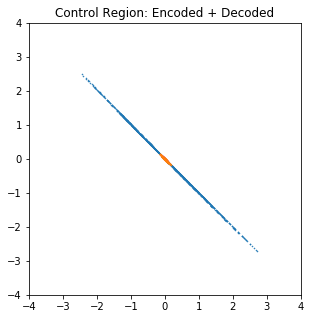

In [311]:
plt.figure(figsize=(20,5))
plt.scatter(decoded_imgs[:,0],decoded_imgs[:,1],s=0.3,color='C0')
plt.scatter(decoded_signal_imgs[:,0],decoded_signal_imgs[:,1],s=0.3,color='C1')
plt.gca().set_aspect(1.)
plt.title("Control Region: Encoded + Decoded")
plt.xlim([-4,4])
plt.ylim([-4,4])

plt.show()

In [312]:
mse_back = []
for i in range(len(bg_plus_signal_CR)):
    mse = ((bg_plus_signal_CR[i] - decoded_imgs[i])**2).mean(axis=None)
    mse_back+=[mse]
    pass
mse_sig = []
for i in range(len(bg_plus_signal_CR)):
    mse = ((sgeventsSR[i] - decoded_signal_imgs[i])**2).mean(axis=None)
    mse_sig+=[mse]
    pass

(array([ 14.,  60., 132., 219., 229., 178., 107.,  41.,  15.,   5.]),
 array([0.18726966, 0.22763039, 0.26799111, 0.30835184, 0.34871257,
        0.3890733 , 0.42943403, 0.46979476, 0.51015548, 0.55051621,
        0.59087694]),
 <a list of 10 Patch objects>)

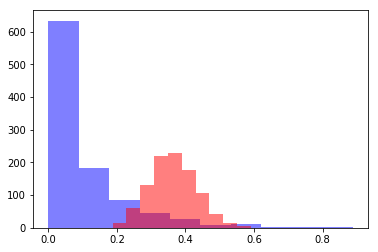

In [316]:
plt.hist(mse_back,alpha=0.5,color='b')
plt.hist(mse_sig,alpha=0.5,color='r')

In [348]:
signal_labels = np.ones(len(mse_sig))
background_labels = np.zeros(len(mse_back))
X = np.concatenate((mse_sig, mse_back))
Y = np.concatenate((signal_labels, background_labels))
fpr, tpr, thresholds = roc_curve(Y,X)

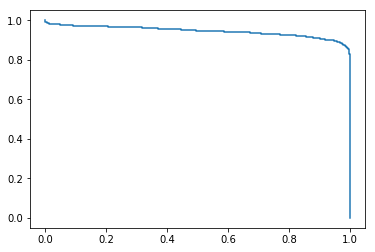

In [349]:
plt.plot(tpr,1-fpr)

Now for CWoLa!

In [330]:
signal_labels = np.ones(len(bg_plus_signal_SR))
background_labels = np.zeros(len(bg_plus_signal_CR))
X = np.concatenate((bg_plus_signal_SR, bg_plus_signal_CR))
Y = np.concatenate((signal_labels, background_labels))

In [335]:
cmodel = Sequential()
cmodel.add(Dense(10, input_dim=2, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(20, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(1, activation='sigmoid'))
cmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [337]:
cmodel.fit(X,Y, epochs=20, batch_size=100)

Epoch 1/20
3000/3000 [==============================] - 0s 52us/step - loss: 0.5704 - acc: 0.6750
Epoch 2/20
3000/3000 [==============================] - 0s 49us/step - loss: 0.5658 - acc: 0.6750
Epoch 3/20
3000/3000 [==============================] - 0s 48us/step - loss: 0.5665 - acc: 0.6790
Epoch 4/20
3000/3000 [==============================] - 0s 48us/step - loss: 0.5665 - acc: 0.6747
Epoch 5/20
3000/3000 [==============================] - 0s 51us/step - loss: 0.5563 - acc: 0.6733
Epoch 6/20
3000/3000 [==============================] - 0s 48us/step - loss: 0.5596 - acc: 0.6793
Epoch 7/20
3000/3000 [==============================] - 0s 52us/step - loss: 0.5603 - acc: 0.6767
Epoch 8/20
3000/3000 [==============================] - 0s 60us/step - loss: 0.5601 - acc: 0.6803
Epoch 9/20
3000/3000 [==============================] - 0s 52us/step - loss: 0.5563 - acc: 0.6777
Epoch 10/20
3000/3000 [==============================] - 0s 48us/step - loss: 0.5538 - acc: 0.6827
Epoch 11/20
3000/30

In [340]:
svals = cmodel.predict(sgeventsSR)
bvals = cmodel.predict(bgeventsSR)

(array([  5.,  15.,  33.,  91., 155., 240., 213., 179.,  53.,  16.]),
 array([0.81890893, 0.82748108, 0.83605323, 0.84462538, 0.85319753,
        0.86176968, 0.87034183, 0.87891397, 0.88748612, 0.89605827,
        0.90463042]),
 <a list of 10 Patch objects>)

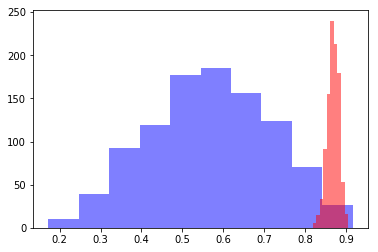

In [343]:
plt.hist(bvals,alpha=0.5,color='b')
plt.hist(svals,alpha=0.5,color='r')

In [347]:
signal_labels = np.ones(len(svals))
background_labels = np.zeros(len(bvals))
X = np.concatenate((svals, bvals))
Y = np.concatenate((signal_labels, background_labels))
cfpr, ctpr, cthresholds = roc_curve(Y,X)

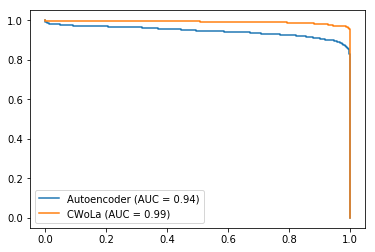

In [363]:
plt.plot(tpr,1-fpr,label="Autoencoder (AUC = %.2f)" % auc(fpr, tpr))
plt.plot(ctpr,1-cfpr,label="CWoLa (AUC = %.2f)" % auc(fpr, ctpr))
plt.legend(loc='lower left')

Now, let's do everything from above, but loop over parameters!

In [82]:
B = 1e4
Strangeness = 0.2
corr = -0.8

auc_auto = []
auc_cwla = []
SoverBvals = [0.1]
while (SoverBvals[len(SoverBvals)-1] > 1e-3):
    SoverBvals+=[SoverBvals[len(SoverBvals)-1]/2]
    pass

for SoverB in SoverBvals:
    
    print("one SoverB of",SoverB)
    
    #First, generate events
    means = [0.,0.]  
    stds = [1.,1.]
    covs = [[stds[0]**2, stds[0]*stds[1]*corr], [stds[0]*stds[1]*corr,stds[1]**2]] 

    bgeventsSR = np.clip(np.random.multivariate_normal(means, covs, int(B)),-4,4)
    bgeventsCR = np.clip(np.random.multivariate_normal(means, covs, int(B)),-4,4)

    signal_center = np.ones(2)*Strangeness*3
    signal_variances = np.ones(2)*0.08**2
    signal_cov = np.diag(signal_variances)
    sgeventsSR = np.clip(np.random.multivariate_normal(signal_center, signal_cov,int(B*SoverB)),-4,4)
    
    bg_plus_signal_SR = np.random.permutation(np.append(bgeventsSR,sgeventsSR,axis=0))
    bg_plus_signal_CR = bgeventsCR    
    
    #Need a bigger sample of signal events just for testing purposes.
    sgeventsSR_fortesting = np.clip(np.random.multivariate_normal(signal_center, signal_cov,int(10*B)),-4,4)
    bgeventsSR_fortesting = np.clip(np.random.multivariate_normal(means, covs, int(10*B)),-4,4)
    
    #For CWoLa, we will need k-folds.
    kfolds = 5
    bg_plus_signal_SR_kfold = {}
    bg_plus_signal_CR_kfold = {}
    sgeventsSR_kfold_fortesting = {}
    bgeventsSR_kfold_fortesting = {}
    for kfold in range(kfolds):
        bg_plus_signal_SR_kfold[kfold] = [[element[0],element[1]] for i, element in enumerate(bg_plus_signal_SR) if i not in range(int(len(bg_plus_signal_SR)*kfold/kfolds),int(len(bg_plus_signal_SR)*(kfold+1)/kfolds))]
        bg_plus_signal_CR_kfold[kfold] = [[element[0],element[1]] for i, element in enumerate(bg_plus_signal_CR) if i not in range(int(len(bg_plus_signal_CR)*kfold/kfolds),int(len(bg_plus_signal_CR)*(kfold+1)/kfolds))]
        #this one is just for testing
        sgeventsSR_kfold_fortesting[kfold] = [[element[0],element[1]] for i, element in enumerate(sgeventsSR_fortesting) if i in range(int(len(sgeventsSR_fortesting)*kfold/kfolds),int(len(sgeventsSR_fortesting)*(kfold+1)/kfolds))]
        bgeventsSR_kfold_fortesting[kfold] = [[element[0],element[1]] for i, element in enumerate(bgeventsSR_fortesting) if i in range(int(len(bgeventsSR_fortesting)*kfold/kfolds),int(len(bgeventsSR_fortesting)*(kfold+1)/kfolds))]
        pass 
    
    #Now, for the autoencoder.
    encoding_dim = 1

    input_img = Input(shape=(2,))
    encoded = Dense(128, activation='elu')(input_img)
    encoded = Dense(64, activation='elu')(encoded)
    encoded = Dense(encoding_dim, activation='linear')(encoded)

    decoded = Dense(encoding_dim, activation='elu')(encoded)
    decoded = Dense(128, activation='elu')(decoded)
    decoded = Dense(2, activation='linear')(decoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    
    autoencoder.fit(bg_plus_signal_CR, bg_plus_signal_CR, epochs=10, batch_size=100)
    
    decoded_imgs = autoencoder.predict(bgeventsSR_fortesting)
    decoded_signal_imgs = autoencoder.predict(sgeventsSR_fortesting)
    
    mse_back = []
    for i in range(len(bgeventsSR_fortesting)):
        mse = ((bgeventsSR_fortesting[i] - decoded_imgs[i])**2).mean(axis=None)
        mse_back+=[mse]
        pass
    mse_sig = []
    for i in range(len(sgeventsSR_fortesting)):
        mse = ((sgeventsSR_fortesting[i] - decoded_signal_imgs[i])**2).mean(axis=None)
        mse_sig+=[mse]
        pass
    
    signal_labels = np.ones(len(mse_sig))
    background_labels = np.zeros(len(mse_back))
    X = np.concatenate((mse_sig, mse_back))
    Y = np.concatenate((signal_labels, background_labels))
    fpr, tpr, thresholds = roc_curve(Y,X)
    auc_auto += [auc(fpr, tpr)]
    
    #Now, CWoLa
    svals_cwola = []
    bvals_cwola = []
    for kfold in range(5):
        
        signal_labels = np.ones(len(bg_plus_signal_SR_kfold[kfold]))
        background_labels = np.zeros(len(bg_plus_signal_CR_kfold[kfold]))
        X = np.concatenate((bg_plus_signal_SR_kfold[kfold], bg_plus_signal_CR_kfold[kfold]))
        Y = np.concatenate((signal_labels, background_labels))
    
        cmodel = Sequential()
        cmodel.add(Dense(10, input_dim=2, activation='elu'))
        cmodel.add(Dropout(0.1))
        cmodel.add(Dense(20, activation='elu'))
        cmodel.add(Dropout(0.1))
        cmodel.add(Dense(1, activation='sigmoid'))
        cmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
        cmodel.fit(X,Y, epochs=5, batch_size=100)
    
        svals_cwola.extend(cmodel.predict(np.array(sgeventsSR_kfold_fortesting[kfold])).flatten())
        bvals_cwola.extend(cmodel.predict(np.array(bgeventsSR_kfold_fortesting[kfold])).flatten())
        pass
    
    signal_labels = np.ones(len(svals_cwola))
    background_labels = np.zeros(len(bvals_cwola))
    X = np.concatenate((svals_cwola, bvals_cwola))
    Y = np.concatenate((signal_labels, background_labels))
    
    cfpr, ctpr, cthresholds = roc_curve(Y,X)
    auc_cwla += [auc(cfpr, ctpr)]
    pass


one SoverB of 0.1
Epoch 1/10
10000/10000 [==============================] - 9s 870us/step - loss: 0.2297
Epoch 2/10
10000/10000 [==============================] - 1s 88us/step - loss: 0.1170
Epoch 3/10
10000/10000 [==============================] - 1s 91us/step - loss: 0.1047
Epoch 4/10
10000/10000 [==============================] - 1s 88us/step - loss: 0.1015
Epoch 5/10
10000/10000 [==============================] - 1s 91us/step - loss: 0.1006
Epoch 6/10
10000/10000 [==============================] - 1s 97us/step - loss: 0.1003
Epoch 7/10
10000/10000 [==============================] - 1s 89us/step - loss: 0.1000
Epoch 8/10
10000/10000 [==============================] - 1s 90us/step - loss: 0.1000
Epoch 9/10
10000/10000 [==============================] - 1s 85us/step - loss: 0.0998
Epoch 10/10
10000/10000 [==============================] - 1s 85us/step - loss: 0.0997
Epoch 1/5
16800/16800 [==============================] - 9s 565us/step - loss: 0.6912 - acc: 0.5251
Epoch 2/5
16800/1680

16200/16200 [==============================] - 10s 617us/step - loss: 0.7020 - acc: 0.4998
Epoch 2/5
16200/16200 [==============================] - 1s 74us/step - loss: 0.6984 - acc: 0.4978
Epoch 3/5
16200/16200 [==============================] - 1s 76us/step - loss: 0.6967 - acc: 0.4989
Epoch 4/5
16200/16200 [==============================] - 1s 76us/step - loss: 0.6949 - acc: 0.5057
Epoch 5/5
16200/16200 [==============================] - 1s 73us/step - loss: 0.6948 - acc: 0.4992
Epoch 1/5
16200/16200 [==============================] - 11s 684us/step - loss: 0.7015 - acc: 0.5062
Epoch 2/5
16200/16200 [==============================] - 1s 71us/step - loss: 0.6966 - acc: 0.5022
Epoch 3/5
16200/16200 [==============================] - 1s 75us/step - loss: 0.6960 - acc: 0.5091
Epoch 4/5
16200/16200 [==============================] - 1s 79us/step - loss: 0.6940 - acc: 0.5128
Epoch 5/5
16200/16200 [==============================] - 1s 74us/step - loss: 0.6943 - acc: 0.5043
Epoch 1/5
16200/

16050/16050 [==============================] - 1s 80us/step - loss: 0.6941 - acc: 0.4978
Epoch 1/5
16049/16049 [==============================] - 12s 724us/step - loss: 0.6992 - acc: 0.4959
Epoch 2/5
16049/16049 [==============================] - 1s 78us/step - loss: 0.6957 - acc: 0.4974
Epoch 3/5
16049/16049 [==============================] - 1s 78us/step - loss: 0.6957 - acc: 0.4965
Epoch 4/5
16049/16049 [==============================] - 1s 79us/step - loss: 0.6943 - acc: 0.5025
Epoch 5/5
16049/16049 [==============================] - 1s 77us/step - loss: 0.6946 - acc: 0.5050
one SoverB of 0.003125
Epoch 1/10
10000/10000 [==============================] - 12s 1ms/step - loss: 0.3577
Epoch 2/10
10000/10000 [==============================] - 1s 99us/step - loss: 0.1326
Epoch 3/10
10000/10000 [==============================] - 1s 100us/step - loss: 0.1169
Epoch 4/10
10000/10000 [==============================] - 1s 102us/step - loss: 0.1097
Epoch 5/10
10000/10000 [=====================

10000/10000 [==============================] - 1s 101us/step - loss: 0.1006
Epoch 1/5
16006/16006 [==============================] - 12s 767us/step - loss: 0.6997 - acc: 0.5013
Epoch 2/5
16006/16006 [==============================] - 1s 89us/step - loss: 0.6966 - acc: 0.5048
Epoch 3/5
16006/16006 [==============================] - 1s 86us/step - loss: 0.6950 - acc: 0.4969
Epoch 4/5
16006/16006 [==============================] - 1s 85us/step - loss: 0.6943 - acc: 0.5034
Epoch 5/5
16006/16006 [==============================] - 1s 86us/step - loss: 0.6944 - acc: 0.5019
Epoch 1/5
16006/16006 [==============================] - 13s 809us/step - loss: 0.7085 - acc: 0.5012
Epoch 2/5
16006/16006 [==============================] - 1s 88us/step - loss: 0.6999 - acc: 0.5003
Epoch 3/5
16006/16006 [==============================] - 1s 94us/step - loss: 0.6982 - acc: 0.4963
Epoch 4/5
16006/16006 [==============================] - 1s 87us/step - loss: 0.6961 - acc: 0.4988
Epoch 5/5
16006/16006 [======

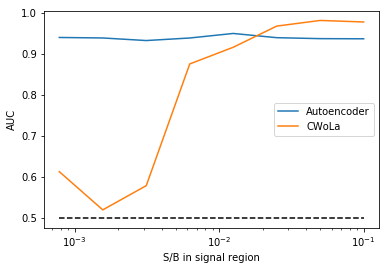

In [88]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(SoverBvals,auc_auto,label="Autoencoder")
plt.plot(SoverBvals,auc_cwla,label="CWoLa")
plt.xlabel('S/B in signal region')
plt.ylabel('AUC')
plt.legend(loc='center right')
plt.plot(np.array([SoverBvals[-1],1e-1]), np.array([0.5,0.5]), linestyle='--',color='black') 
plt.savefig("Comparison_versus_AUC.pdf")

In [123]:
B = 1e5
Strangeness = 0.2
corr = -0.8

auc_auto = []
auc_cwla = []
SoverBvals = [0.1]
while (SoverBvals[len(SoverBvals)-1] > 1e-3):
    SoverBvals+=[SoverBvals[len(SoverBvals)-1]/2]
    pass

for SoverB in SoverBvals:
    
    print("one SoverB of",SoverB)
    
    #First, generate events
    means = [0.,0.]  
    stds = [1.,1.]
    covs = [[stds[0]**2, stds[0]*stds[1]*corr], [stds[0]*stds[1]*corr,stds[1]**2]] 

    bgeventsSR = np.clip(np.random.multivariate_normal(means, covs, int(B)),-4,4)
    bgeventsCR = np.clip(np.random.multivariate_normal(means, covs, int(B)),-4,4)

    signal_center = np.ones(2)*Strangeness*3
    signal_variances = np.ones(2)*0.08**2
    signal_cov = np.diag(signal_variances)
    sgeventsSR = np.clip(np.random.multivariate_normal(signal_center, signal_cov,int(B*SoverB)),-4,4)
    
    bg_plus_signal_SR = np.random.permutation(np.append(bgeventsSR,sgeventsSR,axis=0))
    bg_plus_signal_CR = bgeventsCR    
    
    #Need a bigger sample of signal events just for testing purposes.
    sgeventsSR_fortesting = np.clip(np.random.multivariate_normal(signal_center, signal_cov,int(2*B)),-4,4)
    bgeventsSR_fortesting = np.clip(np.random.multivariate_normal(means, covs, int(2*B)),-4,4)
    
    #For CWoLa, we will need k-folds.
    kfolds = 5
    bg_plus_signal_SR_kfold = {}
    bg_plus_signal_CR_kfold = {}
    sgeventsSR_kfold_fortesting = {}
    bgeventsSR_kfold_fortesting = {}
    for kfold in range(kfolds):
        bg_plus_signal_SR_kfold[kfold] = [[element[0],element[1]] for i, element in enumerate(bg_plus_signal_SR) if i not in range(int(len(bg_plus_signal_SR)*kfold/kfolds),int(len(bg_plus_signal_SR)*(kfold+1)/kfolds))]
        bg_plus_signal_CR_kfold[kfold] = [[element[0],element[1]] for i, element in enumerate(bg_plus_signal_CR) if i not in range(int(len(bg_plus_signal_CR)*kfold/kfolds),int(len(bg_plus_signal_CR)*(kfold+1)/kfolds))]
        #this one is just for testing
        sgeventsSR_kfold_fortesting[kfold] = [[element[0],element[1]] for i, element in enumerate(sgeventsSR_fortesting) if i in range(int(len(sgeventsSR_fortesting)*kfold/kfolds),int(len(sgeventsSR_fortesting)*(kfold+1)/kfolds))]
        bgeventsSR_kfold_fortesting[kfold] = [[element[0],element[1]] for i, element in enumerate(bgeventsSR_fortesting) if i in range(int(len(bgeventsSR_fortesting)*kfold/kfolds),int(len(bgeventsSR_fortesting)*(kfold+1)/kfolds))]
        pass 
    
    #Now, for the autoencoder.
    encoding_dim = 1

    input_img = Input(shape=(2,))
    encoded = Dense(128, activation='elu')(input_img)
    encoded = Dense(64, activation='elu')(encoded)
    encoded = Dense(encoding_dim, activation='linear')(encoded)

    decoded = Dense(encoding_dim, activation='elu')(encoded)
    decoded = Dense(128, activation='elu')(decoded)
    decoded = Dense(2, activation='linear')(decoded)

    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    
    autoencoder.fit(bg_plus_signal_CR, bg_plus_signal_CR, epochs=2, batch_size=100)
    
    decoded_imgs = autoencoder.predict(bgeventsSR_fortesting)
    decoded_signal_imgs = autoencoder.predict(sgeventsSR_fortesting)
    
    mse_back = []
    for i in range(len(bgeventsSR_fortesting)):
        mse = ((bgeventsSR_fortesting[i] - decoded_imgs[i])**2).mean(axis=None)
        mse_back+=[mse]
        pass
    mse_sig = []
    for i in range(len(sgeventsSR_fortesting)):
        mse = ((sgeventsSR_fortesting[i] - decoded_signal_imgs[i])**2).mean(axis=None)
        mse_sig+=[mse]
        pass
    
    signal_labels = np.ones(len(mse_sig))
    background_labels = np.zeros(len(mse_back))
    X = np.concatenate((mse_sig, mse_back))
    Y = np.concatenate((signal_labels, background_labels))
    fpr, tpr, thresholds = roc_curve(Y,X)
    auc_auto += [auc(fpr, tpr)]
    
    #Now, CWoLa
    svals_cwola = []
    bvals_cwola = []
    for kfold in range(5):
        
        signal_labels = np.ones(len(bg_plus_signal_SR_kfold[kfold]))
        background_labels = np.zeros(len(bg_plus_signal_CR_kfold[kfold]))
        X = np.concatenate((bg_plus_signal_SR_kfold[kfold], bg_plus_signal_CR_kfold[kfold]))
        Y = np.concatenate((signal_labels, background_labels))
    
        cmodel = Sequential()
        cmodel.add(Dense(10, input_dim=2, activation='elu'))
        cmodel.add(Dropout(0.1))
        cmodel.add(Dense(20, activation='elu'))
        cmodel.add(Dropout(0.1))
        cmodel.add(Dense(1, activation='sigmoid'))
        cmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
        cmodel.fit(X,Y, epochs=2, batch_size=100)
    
        svals_cwola.extend(cmodel.predict(np.array(sgeventsSR_kfold_fortesting[kfold])).flatten())
        bvals_cwola.extend(cmodel.predict(np.array(bgeventsSR_kfold_fortesting[kfold])).flatten())
        pass
    
    signal_labels = np.ones(len(svals_cwola))
    background_labels = np.zeros(len(bvals_cwola))
    X = np.concatenate((svals_cwola, bvals_cwola))
    Y = np.concatenate((signal_labels, background_labels))
    
    cfpr, ctpr, cthresholds = roc_curve(Y,X)
    auc_cwla += [auc(cfpr, ctpr)]
    pass

one SoverB of 0.1
Epoch 1/2
100000/100000 [==============================] - 36s 357us/step - loss: 0.1221
Epoch 2/2
100000/100000 [==============================] - 13s 127us/step - loss: 0.1010
Epoch 1/2
168000/168000 [==============================] - 39s 232us/step - loss: 0.6900 - acc: 0.5224
Epoch 2/2
168000/168000 [==============================] - 19s 115us/step - loss: 0.6879 - acc: 0.5226
Epoch 1/2
168000/168000 [==============================] - 40s 237us/step - loss: 0.6895 - acc: 0.5231
Epoch 2/2
168000/168000 [==============================] - 21s 126us/step - loss: 0.6869 - acc: 0.5250
Epoch 1/2
168000/168000 [==============================] - 41s 244us/step - loss: 0.6884 - acc: 0.5235
Epoch 2/2
168000/168000 [==============================] - 20s 118us/step - loss: 0.6868 - acc: 0.5247
Epoch 1/2
168000/168000 [==============================] - 41s 243us/step - loss: 0.6893 - acc: 0.5235
Epoch 2/2
168000/168000 [==============================] - 20s 117us/step - loss: 0

160125/160125 [==============================] - 46s 286us/step - loss: 0.6952 - acc: 0.4995
Epoch 2/2
160125/160125 [==============================] - 24s 147us/step - loss: 0.6934 - acc: 0.5010
Epoch 1/2
160124/160124 [==============================] - 46s 286us/step - loss: 0.6956 - acc: 0.5019
Epoch 2/2
160124/160124 [==============================] - 23s 146us/step - loss: 0.6935 - acc: 0.5014
one SoverB of 0.00078125
Epoch 1/2
100000/100000 [==============================] - 39s 389us/step - loss: 0.1286
Epoch 2/2
100000/100000 [==============================] - 16s 164us/step - loss: 0.1014
Epoch 1/2
160063/160063 [==============================] - 46s 288us/step - loss: 0.6948 - acc: 0.4987
Epoch 2/2
160063/160063 [==============================] - 24s 147us/step - loss: 0.6936 - acc: 0.4990
Epoch 1/2
160062/160062 [==============================] - 46s 290us/step - loss: 0.6954 - acc: 0.5008
Epoch 2/2
160062/160062 [==============================] - 24s 149us/step - loss: 0.69

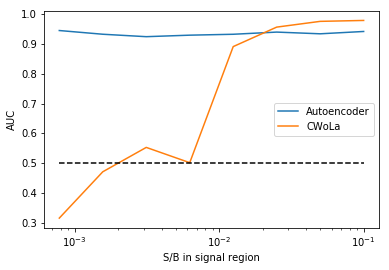

In [124]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(SoverBvals,auc_auto,label="Autoencoder")
plt.plot(SoverBvals,auc_cwla,label="CWoLa")
plt.xlabel('S/B in signal region')
plt.ylabel('AUC')
plt.legend(loc='center right')
plt.plot(np.array([SoverBvals[-1],1e-1]), np.array([0.5,0.5]), linestyle='--',color='black') 
plt.savefig("Comparison_versus_AUC.pdf")